   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


/tmp/ipython-input-2662288746.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed


Price       Date   Close    High     Low    Open   Volume
233   2025-12-08  1440.0  1440.0  1405.0  1430.0  5746578
234   2025-12-09  1420.0  1440.0  1415.0  1435.0  4993367
235   2025-12-10  1460.0  1460.0  1425.0  1435.0  8224726
236   2025-12-11  1395.0  1450.0  1395.0  1445.0  8965596
237   2025-12-12  1405.0  1415.0  1380.0  1390.0  5029971


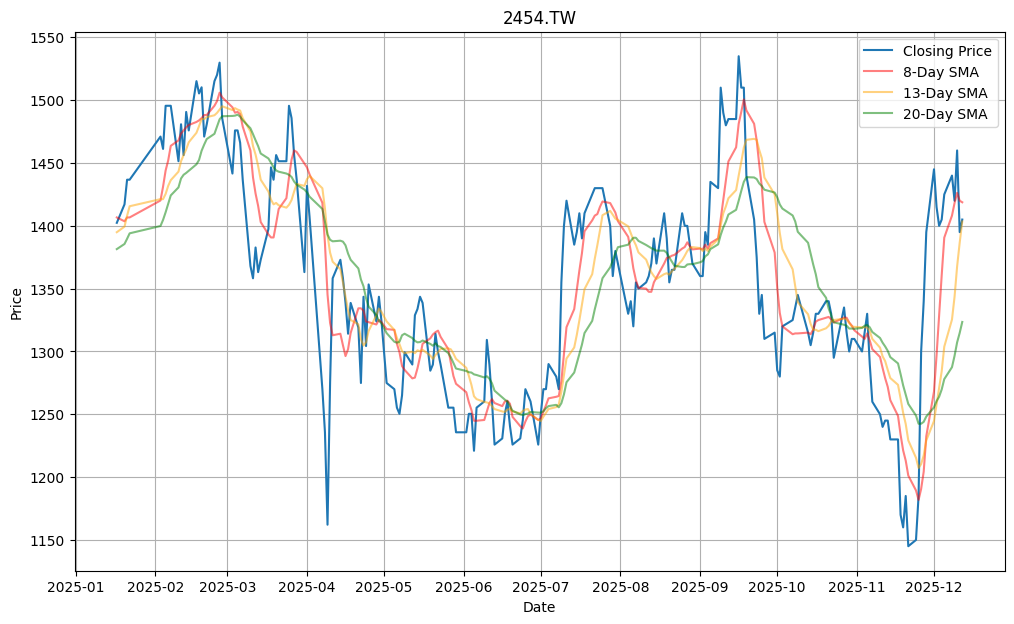

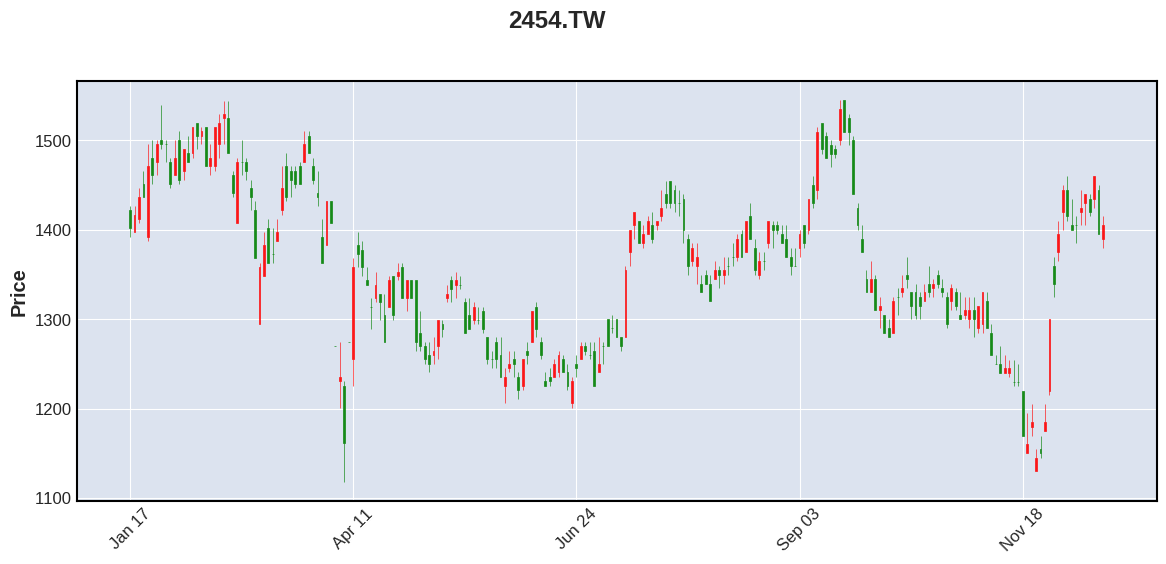

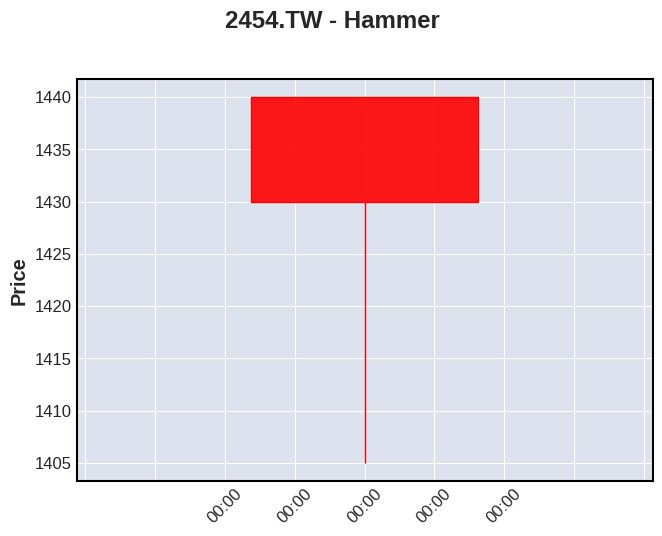

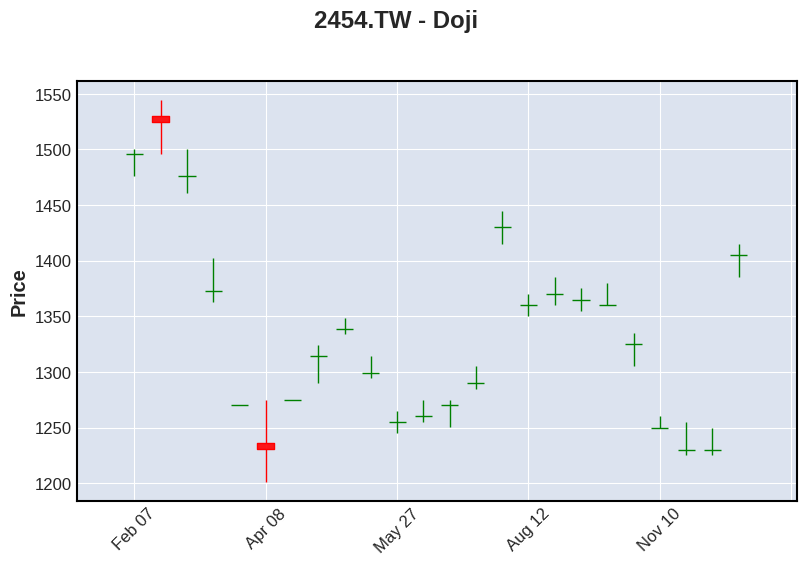

Linear Regression RMSE: 42.44
Decision Tree RMSE: 63.61
Random Forest RMSE: 43.39


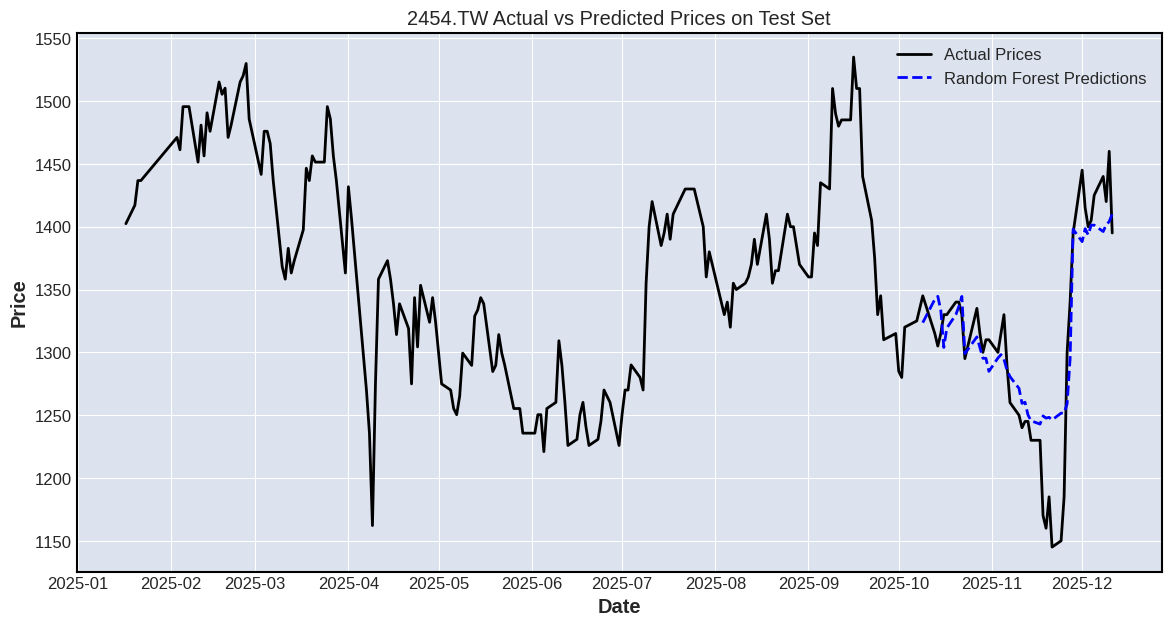

Random Forest Future Price Prediction: 1410.20


In [1]:
# [1] 環境建置
!pip install yfinance mplfinance

import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# [2] 取得資料
stock_id = "2454.TW"
end = dt.date.today()
start = end - dt.timedelta(days=360)

df = yf.download(stock_id, start=start, end=end).reset_index()

if 'Ticker' in df.columns.names:
    df.columns = df.columns.droplevel('Ticker')

print(df.tail())

# [3] 計算技術指標
# 3.1 SMA
df['8_SMA'] = df['Close'].rolling(window=8).mean()
df['13_SMA'] = df['Close'].rolling(window=13).mean()
df['20_SMA'] = df['Close'].rolling(window=20).mean()

# 3.2 RSI
df['Change'] = df['Close'] - df['Close'].shift(1)
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)
df['Avg Gain'] = df['Gain'].rolling(window=14).mean()
df['Avg Loss'] = df['Loss'].rolling(window=14).mean()
df['RS'] = df['Avg Gain'] / df['Avg Loss']
df['RSI'] = 100 - (100 / (1 + df['RS']))

# 3.3 MACD
df['EMA_8'] = df['Close'].ewm(span=8, adjust=False).mean()
df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean()
df['MACD'] = df['EMA_8'] - df['EMA_13']

df.dropna(inplace=True)

# [4] 資料可視化
# 4.1 收盤價與 SMA
plt.figure(figsize=(12, 7))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.plot(df['Date'], df['8_SMA'], label='8-Day SMA', color='red', alpha=.5)
plt.plot(df['Date'], df['13_SMA'], label='13-Day SMA', color='orange', alpha=.5)
plt.plot(df['Date'], df['20_SMA'], label='20-Day SMA', color='green', alpha=.5)
plt.title(f'{stock_id}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 4.2 K 線圖
kplot_df = df.set_index('Date')
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default', marketcolors=my_color)
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))

# 4.3 Hammer 型態
df['body_length'] = abs(df['Close'] - df['Open'])
df['lower_shadow'] = abs(df['Low'] - df[['Open', 'Close']].min(axis=1))
df['upper_shadow'] = abs(df['High'] - df[['Open', 'Close']].max(axis=1))

hammer_condition = (
    (df['lower_shadow'] > 2 * df['body_length']) &
    (df['upper_shadow'] < df['body_length'] * 0.1) &
    (df['body_length'] < (df['High'] - df['Low']) * 0.4)
)
hammer_df = df[hammer_condition].set_index('Date')

if not hammer_df.empty:
    mpf.plot(hammer_df, type='candle', style=my_style, title=f'{stock_id} - Hammer')

# 4.4 Doji 型態
doji_condition = (
    df['body_length'] <= (df['High'] - df['Low']) * 0.1
)
doji_df = df[doji_condition].set_index('Date')

if not doji_df.empty:
    mpf.plot(doji_df, type='candle', style=my_style, title=f'{stock_id} - Doji', figsize=(10, 6))

# [5] 機器學習預測
n = 1
df['Future_Price'] = df['Close'].shift(-n)
data_ml = df.dropna().copy()

X = data_ml[['20_SMA', 'RSI', 'MACD']]
y = data_ml['Future_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5.1 Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

# 5.2 Decision Tree
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(f"Decision Tree RMSE: {rmse_dt:.2f}")

# 5.3 Random Forest
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.2f}")

# 5.4 Visualization (Random Forest)
plt.figure(figsize=(14, 7))
plt.plot(data_ml['Date'], data_ml['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(data_ml['Date'].iloc[-len(y_test):], y_pred_rf, label='Random Forest Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{stock_id} Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# 5.5 Future Prediction
future_pred = model_rf.predict(X.iloc[[-1]])
print(f"Random Forest Future Price Prediction: {future_pred[0]:.2f}")